<a href="https://colab.research.google.com/github/ms-shyamkumar/demand-forecasting/blob/main/demand_forecast_electricity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Electricity Demand Forecasting**

Electricity Demand Forecasting based on daily data of electricity demand from the POSOCO website from Jan-2017 to Dec-2020. The data provides the daily peak hour demand met (in MegaWatt) for each region in India (North, East, West, South and North East). Installed capacity is also taken from the report to forecast based on a logistic growth.
The aim is to forecast demand and identify when the demand would reach 75% utilization to initiate capacity upgrade.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [2]:
demand_file = 'posoco_electricty_demand_met.csv'
capacity_file = 'posoco_installed_capacity.csv'

In [3]:
#demand file
demand_df = pd.read_csv(demand_file)
print(demand_df.shape)
demand_df.head(3)

(7305, 3)


,Date,Demand_MW,Region
0,12/01/20,46076,North
1,12/02/20,46523,North
2,12/03/20,47150,North


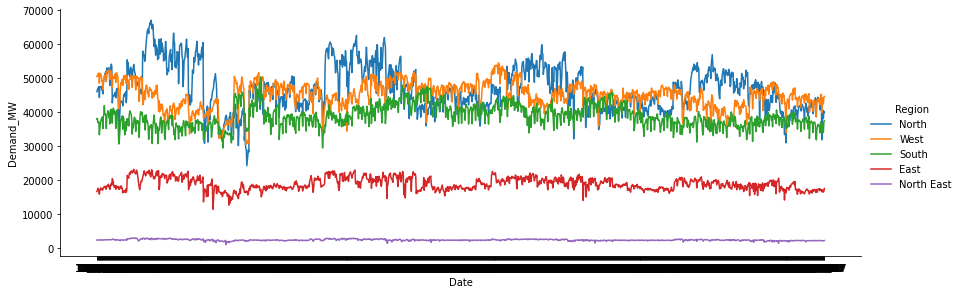

In [4]:
sns.relplot(x='Date', y='Demand_MW', data=demand_df, hue='Region', kind='line', aspect=3, height=4);

Since data is from 2017, the effect of lockdown is minimal and the model should be able to capture the trend and seasonality fairly well. Of the various regions, growth in north seems to be higher and capacity comparatively lesser. We will use fbprophet to model the timeseries and forecast demand into future to understand when capacity upgrades need to be initiated

In [5]:
#capacity file and present capacity calculation
cap_df = pd.read_csv(capacity_file)
present_cap = cap_df[(cap_df['Month']==cap_df['Month'].max())][['Region','Total Capacity (MW)']]
present_cap.head()

,Region,Total Capacity (MW)
0,North,100145
1,West,123411
2,South,113460
3,East,33594
4,North East,4637


In [6]:
#convert column names to ds and y as per fbprophet requirement and
#create a list of regions for regional forecasts 
demand_df.columns =['ds', 'y', 'Region']
demand_df['ds'] = demand_df['ds'].astype('datetime64[ns]')
regions = demand_df['Region'].unique()

In [7]:
def predict_demand(demand, capacity, series_label):
  '''Takes historical demand data and predicts future 
  550 days of forecast.
  Arguments: 
  demand: datframe containing historical data in the form [ds,y]
  capacity: scalar value for max capacity of the system
  series_label: a string for printing chart title
   '''
  regional_demand['cap']= capacity
  m = Prophet(growth='logistic')
  m.fit(regional_demand)
  future = m.make_future_dataframe(periods=550)
  future['cap'] = capacity
  forecast = m.predict(future)
  fig, ax = plt.subplots(figsize=(16,4))
  m.plot(forecast, xlabel='Date', ylabel='Demand (MW)', ax=ax)
  ax.set(title=series_label)

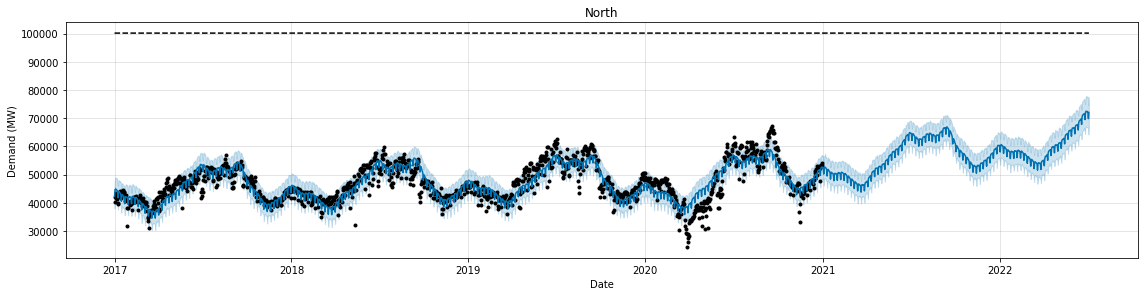

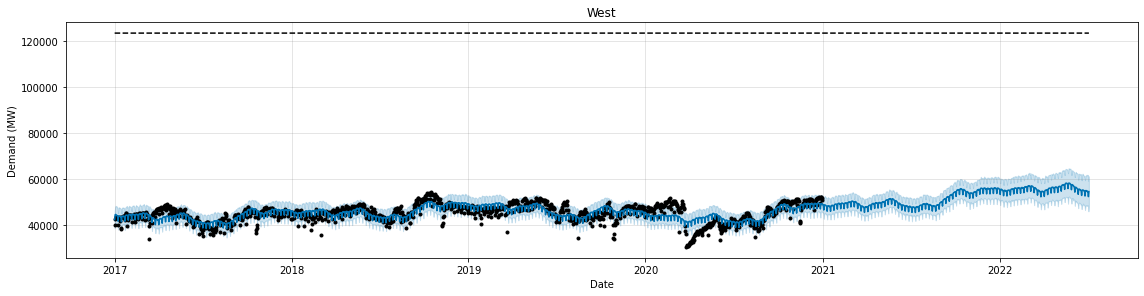

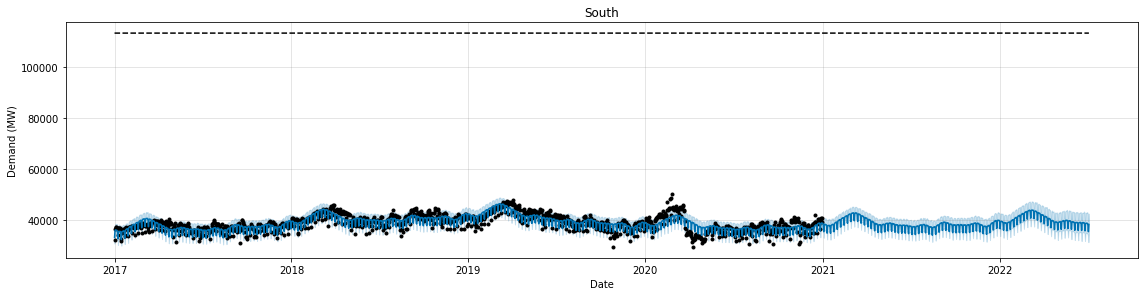

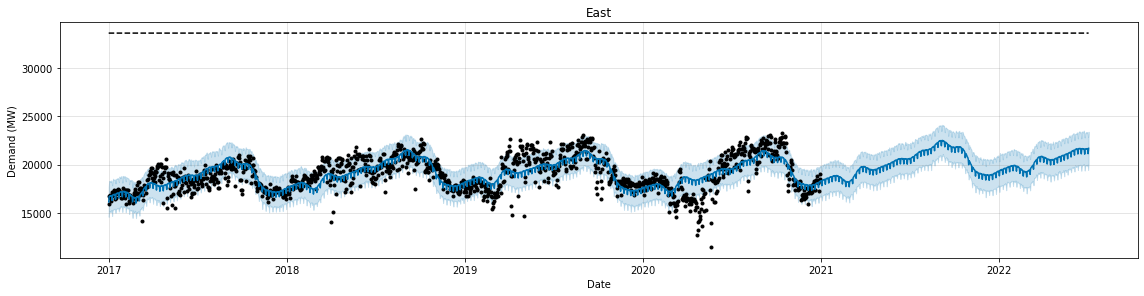

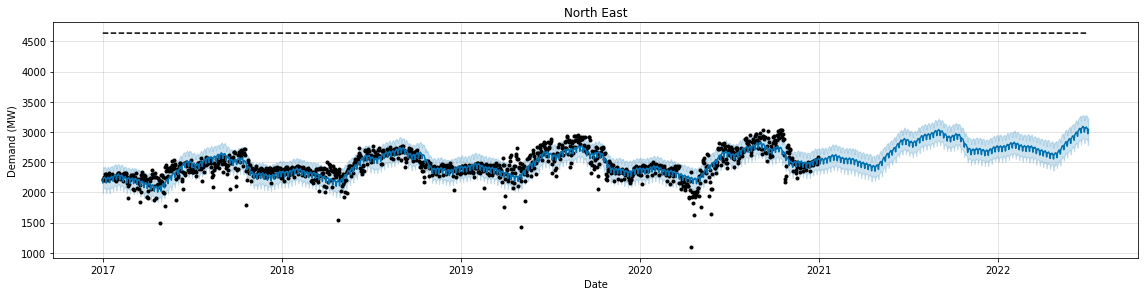

In [8]:
for region in regions:
  regional_demand = demand_df[demand_df['Region']==region][['ds','y']]
  regional_cap = present_cap[present_cap['Region']==region]['Total Capacity (MW)'].values[0]
  predict_demand(regional_demand, regional_cap, region)

The above forecast shows except for North, no specific region requires immediate capacity upgrade. The graph also show regions like a declining electricity demand even in 2019 in South and West, maybe due to an economic slow down which started much before covid-19 impact.
The capacity build triggering threshold can be decided based on lead time for capacity build and growth rate of demand.

**Model Evaluation**

Evaluating the model to check error and choose between linear and logistic growth models on a sample of north region data which has significant growth.

In [9]:
north_demand = demand_df[demand_df['Region']=='North'][['ds','y']]
north_capacity = present_cap[present_cap['Region']=='North']['Total Capacity (MW)'].values[0]
north_capacity

100145

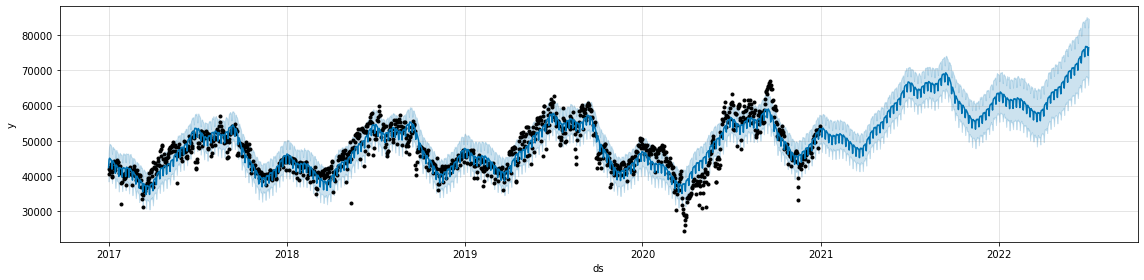

In [10]:
#linear growth
model_lin = Prophet()
model_lin.fit(north_demand)
future_lin = model_lin.make_future_dataframe(periods=550)
forecast_lin = model_lin.predict(future_lin)
fig_lin = model_lin.plot(forecast_lin,figsize=(16,4) )

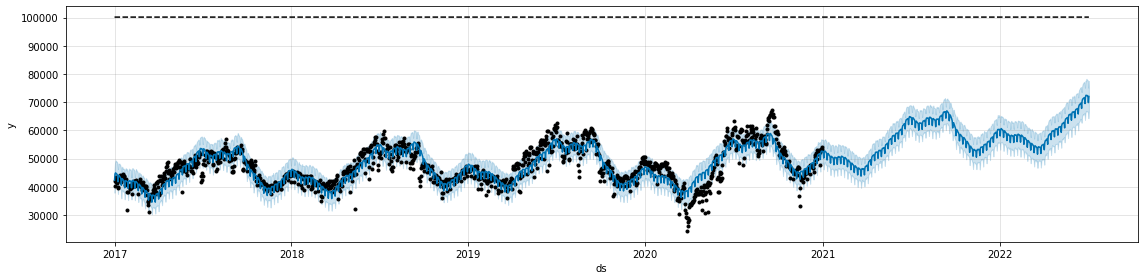

In [11]:
#logistic growth
north_demand['cap']= north_capacity
model_log = Prophet(growth='logistic')
model_log.fit(north_demand)
future_log = model_log.make_future_dataframe(periods=550)
future_log['cap'] = north_capacity
forecast_log = model_log.predict(future_log)
fig_log = model_log.plot(forecast_log, figsize=(16,4) )

In [12]:
df_cv1 = cross_validation(model_lin, initial='730 days', period='180 days', horizon = '365 days')
df_p1 = performance_metrics(df_cv1)

In [13]:
df_cv2 = cross_validation(model_log, initial='730 days', period='180 days', horizon = '365 days')
df_p2 = performance_metrics(df_cv2)

The below charts shows linear growth is too optimistic and logistic growth is much realistic for electricity demand, eventhough the rmse is better for linear growth type for certain forecasts

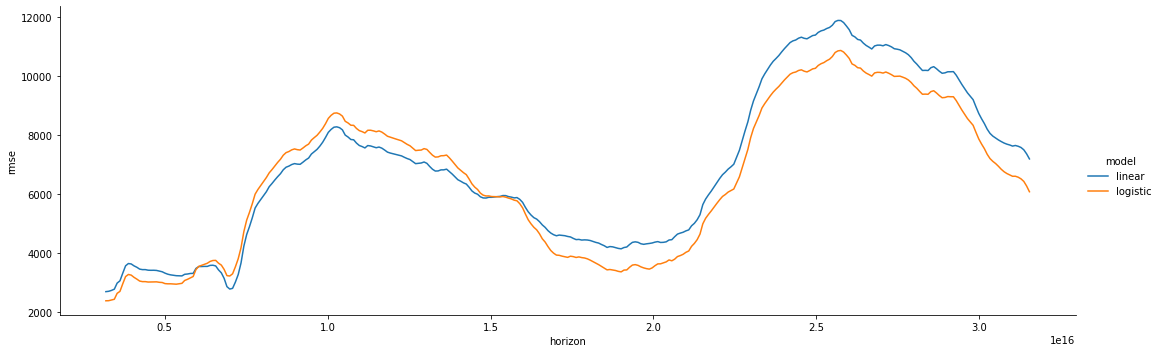

In [14]:
#root mean square error evaluation
df1=df_p1[['horizon','rmse']].copy()
df1['model']='linear'
df2=df_p2[['horizon','rmse']].copy()
df2['model']='logistic'
dfc = df1.append(df2)
sns.relplot(y='rmse', x='horizon', kind='line', data=dfc, hue='model', aspect=3, height=5);

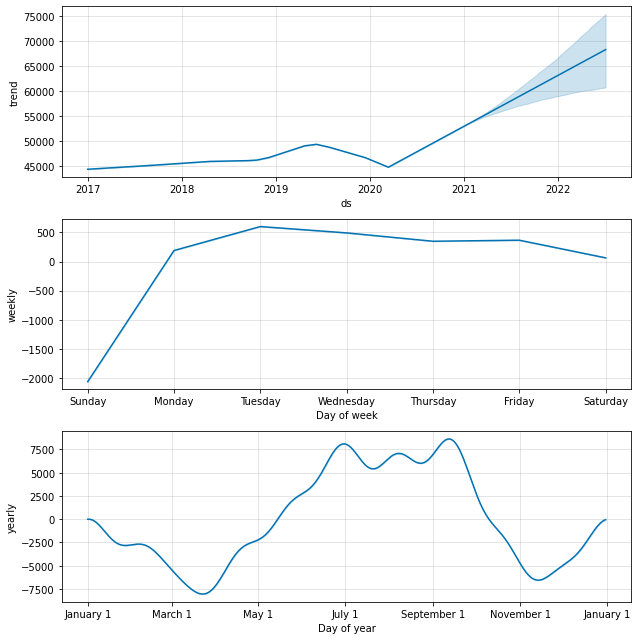

In [15]:
fig1 = model_lin.plot_components(forecast_lin)

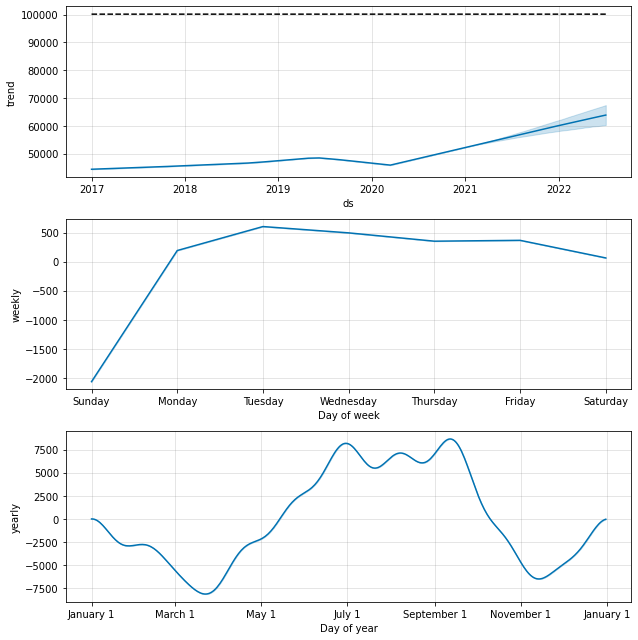

In [16]:
fig2 = model_log.plot_components(forecast_log)